<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points) 

Write a report about experiments and results, add plots and visualizations.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw



In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

### Create generator and discriminator

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1) 
            # modification1: remove sigmoid
            # nn.Sigmoid()
            )
    def forward(self, x):
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [10]:
# modification2: use RMSprop (or SGD) instead of Adam
# optimizer
# optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
# optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)
optim_G = optim.RMSprop(params=generator.parameters(),lr=0.00005)
optim_D = optim.RMSprop(params=discriminator.parameters(),lr=0.00005)

# modification4: no log in loss
# criterion = nn.BCELoss()

### Create necessary variables

In [44]:
from torch.utils.tensorboard import SummaryWriter
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

# for tensorboard plotting
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

generator.train()
discriminator.train()

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=200, out_features=50, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=50, out_features=1, bias=True)
  )
)

### WGAN

In [12]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
#WGAN modified of DCGAN in:
#1. remove sigmoid in the last layer of discriminator(classification -> regression)
#2. no log Loss (Wasserstein distance)
#3. clip param norm to c (Wasserstein distance and Lipschitz continuity)
#4. No momentum-based optimizer, use RMSProp，SGD instead

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        # Train Critic: max E[critic(real)] - E[critic(fake)]
        # CRITIC_ITERATIONS = 5
        # optim_D.zero_grad()
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        # errD_x = criterion(output, label)
        # ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output_fake = discriminator(fake.detach())
        # errD_z = criterion(output, label)
        # ERRD_z[epoch] += errD_z.item()
        # errD_z.backward()

        loss_critic = -(torch.mean(output_real) - torch.mean(output_fake))


        loss_critic.backward(retain_graph=True)
        optim_D.step()
        
        # modification3: clip param norm to c=0.01 (Wasserstein distance and Lipschitz continuity)
        for parm in discriminator.parameters():
            parm.data.clamp_(-0.01, 0.01)


        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator.zero_grad()
        label.data.fill_(real_label)
        gen_fake = discriminator(fake)
        loss_gen = -torch.mean(gen_fake)

        loss_gen.backward()

        optim_G.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # generator.zero_grad()
        # label.data.fill_(real_label)
        # output = discriminator(fake)
        # errG = criterion(output, label)
        # ERRG[epoch] += errG.item()
        # errG.backward()
        
        # optim_G.step()
        '''
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
        '''
        
        # Print losses occasionally and print to tensorboard
        if iteration % 100 == 0 and iteration > 0:
            generator.eval()
            discriminator.eval()
            print(
                f"Epoch [{epoch+1}/{10}] Batch {iteration}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    images[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            generator.train()
            discriminator.train()

Epoch [1/10] Batch 100/3750                   Loss D: -0.0831, loss G: 0.0477
Epoch [1/10] Batch 200/3750                   Loss D: -0.1262, loss G: 0.0871
Epoch [1/10] Batch 300/3750                   Loss D: -0.1440, loss G: 0.1186
Epoch [1/10] Batch 400/3750                   Loss D: -0.1377, loss G: 0.1520
Epoch [1/10] Batch 500/3750                   Loss D: -0.1062, loss G: 0.1657
Epoch [1/10] Batch 600/3750                   Loss D: -0.1075, loss G: 0.1733
Epoch [1/10] Batch 700/3750                   Loss D: -0.0975, loss G: 0.1796
Epoch [1/10] Batch 800/3750                   Loss D: -0.1053, loss G: 0.1604
Epoch [1/10] Batch 900/3750                   Loss D: -0.1035, loss G: 0.1287
Epoch [1/10] Batch 1000/3750                   Loss D: -0.0981, loss G: 0.0668
Epoch [1/10] Batch 1100/3750                   Loss D: -0.1196, loss G: 0.0480
Epoch [1/10] Batch 1200/3750                   Loss D: -0.1196, loss G: 0.0227
Epoch [1/10] Batch 1300/3750                   Loss D: -0.089

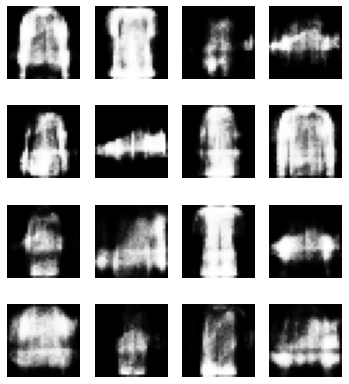

In [13]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Replace  weight clipping with gradient penalty \# WGAN_gp

In [68]:
def gradient_penalty(critic, real, fake):
    real = real.view(16, 784)
    alpha = torch.rand((16, 784))
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [21]:
# switch algorighm back to Adam
optimD = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimG = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [69]:
for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output_real = discriminator(input_data)
        # errD_x = criterion(output, label)
        # ERRD_x[epoch] += errD_x.item()
        # errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output_fake = discriminator(fake.detach())
        
        # add gp here
        gp = gradient_penalty(discriminator, images, fake)
        loss_critic = (
                -(torch.mean(output_real) - torch.mean(output_fake)) + 10 * gp # LAMBDA_GP = 10
            )
        discriminator.zero_grad()
        loss_critic.backward(retain_graph=True)
        optim_D.step()



        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        generator.zero_grad()
        label.data.fill_(real_label)
        gen_fake = discriminator(fake)
        loss_gen = -torch.mean(gen_fake)

        loss_gen.backward()

        optim_G.step()

        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # generator.zero_grad()
        # label.data.fill_(real_label)
        # output = discriminator(fake)
        # errG = criterion(output, label)
        # ERRG[epoch] += errG.item()
        # errG.backward()
        
        # optim_G.step()
        '''
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
        '''
        
        # Print losses occasionally and print to tensorboard
        if iteration % 100 == 0 and iteration > 0:
            generator.eval()
            discriminator.eval()
            print(
                f"Epoch [{epoch+1}/{10}] Batch {iteration}/{len(dataloader)} \
                  Loss D: {loss_critic:.4f}, loss G: {loss_gen:.4f}"
            )

            with torch.no_grad():
                fake = generator(noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    images[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1
            generator.train()
            discriminator.train()

Epoch [1/10] Batch 100/3750                   Loss D: 3.2354, loss G: -2.8942
Epoch [1/10] Batch 200/3750                   Loss D: 2.9259, loss G: -5.2808
Epoch [1/10] Batch 300/3750                   Loss D: 2.0032, loss G: -3.2790
Epoch [1/10] Batch 400/3750                   Loss D: 1.6160, loss G: -1.8043
Epoch [1/10] Batch 500/3750                   Loss D: 2.6436, loss G: -0.5897
Epoch [1/10] Batch 600/3750                   Loss D: 7.8904, loss G: -0.0131
Epoch [1/10] Batch 700/3750                   Loss D: 8.4650, loss G: 0.1219
Epoch [1/10] Batch 800/3750                   Loss D: 8.0735, loss G: 0.1878
Epoch [1/10] Batch 900/3750                   Loss D: 7.9343, loss G: 0.2600
Epoch [1/10] Batch 1000/3750                   Loss D: 6.7704, loss G: 0.3717
Epoch [1/10] Batch 1100/3750                   Loss D: 5.6884, loss G: 0.2963
Epoch [1/10] Batch 1200/3750                   Loss D: 4.7424, loss G: 0.2556
Epoch [1/10] Batch 1300/3750                   Loss D: 4.5042, loss

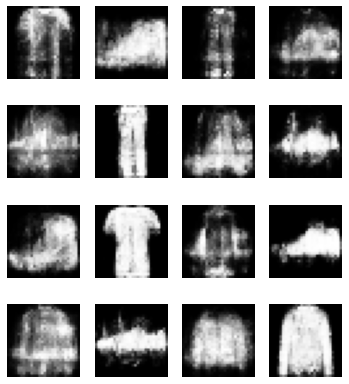

In [70]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Add labels into WGAN, performing conditional generation \#CGAN

In [164]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)

    def forward(self, x, labels):
        x = x.view(x.size(0), 50)
        gen_input = torch.cat((x, self.label_emb(labels)), 1)
        img = self.model(gen_input)
        
        return img.view(x.size(0), 28, 28)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28+10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
        self.label_emb = nn.Embedding(10, 10)
        
    def forward(self, x, labels):
        #print(x.size())
        d_in = torch.cat((x.view(x.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

In [165]:
generator = Generator()
discriminator = Discriminator()

optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

In [166]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))

In [167]:
ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = discriminator(input_data, cat)
        errD_x = criterion(output.view(16), label)
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise, cat)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach(), cat).view(16)
        errD_z = criterion(output, label)
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake, cat).view(16)
        errG = criterion(output, label)
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))

Epoch:1 Iter: 100 errD_x: 0.17 errD_z: 0.08 errG: 2.60
Epoch:1 Iter: 200 errD_x: 0.19 errD_z: 0.09 errG: 2.80
Epoch:1 Iter: 300 errD_x: 0.16 errD_z: 0.17 errG: 2.40
Epoch:1 Iter: 400 errD_x: 0.07 errD_z: 0.10 errG: 2.65
Epoch:1 Iter: 500 errD_x: 0.14 errD_z: 0.06 errG: 3.17
Epoch:1 Iter: 600 errD_x: 0.07 errD_z: 0.09 errG: 2.52
Epoch:1 Iter: 700 errD_x: 0.11 errD_z: 0.14 errG: 2.51
Epoch:1 Iter: 800 errD_x: 0.37 errD_z: 0.08 errG: 2.81
Epoch:1 Iter: 900 errD_x: 0.05 errD_z: 0.06 errG: 3.24
Epoch:1 Iter: 1000 errD_x: 0.25 errD_z: 0.17 errG: 2.40
Epoch:1 Iter: 1100 errD_x: 0.08 errD_z: 0.12 errG: 2.63
Epoch:1 Iter: 1200 errD_x: 0.29 errD_z: 0.15 errG: 2.29
Epoch:1 Iter: 1300 errD_x: 0.06 errD_z: 0.13 errG: 2.54
Epoch:1 Iter: 1400 errD_x: 0.48 errD_z: 0.17 errG: 2.54
Epoch:1 Iter: 1500 errD_x: 0.09 errD_z: 0.26 errG: 2.30
Epoch:1 Iter: 1600 errD_x: 0.25 errD_z: 0.15 errG: 2.76
Epoch:1 Iter: 1700 errD_x: 0.05 errD_z: 0.26 errG: 2.35
Epoch:1 Iter: 1800 errD_x: 0.14 errD_z: 0.15 errG: 2.91
E

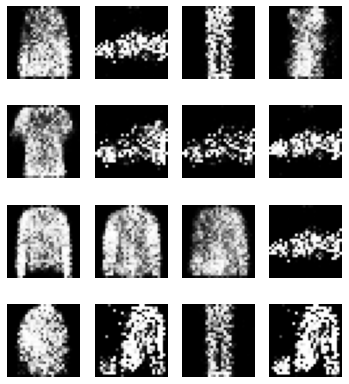

In [168]:
noise.data.normal_(0, 1)
fake = generator(noise, cat)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

### Write a report about experiments and results, add plots and visualizations.

As is seen in the previous three tasks, WGAN, WGAN-gp and CGAN trying different approaches to improve the simple GAN (for WGAN and WGAN-gp is about adding gradient penalty), as GAN has problems like difficultly to train, the loss of the generator and the discriminator cannot indicate the training process, and the lack of diversity in the generated samples. Merely based on the fix_noise samples, I think the WGAN-gp performs better than WGAN, and WGAN is better than CGAN, in a sense of creating samples' quality, visually.

And there should be some plots and detailed analysis on how different model's performance rather than merely run some epoch. However, I'm just exhausted of understanding these amazing papers. So I think maybe I would just stop here, wish you merry christmas, best regards.



Yu